## Import libraries

In [137]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm

from statsmodels.stats.outliers_influence \
    import variance_inflation_factor as vif
from statsmodels.stats.anova import anova_lm

from ISLP import load_data
from ISLP.models import (ModelSpec as MS, summarize, poly)

from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import r2_score

## Simple linear regression

Boston housing dataset is used to illustrate the general procedure applying linear regression 

In [79]:
df = load_data("Boston")
df.columns

Index(['crim', 'zn', 'indus', 'chas', 'nox', 'rm', 'age', 'dis', 'rad', 'tax',
       'ptratio', 'lstat', 'medv'],
      dtype='object')

### reduced example statsmodels

In [80]:
X = pd.DataFrame({
    "intercept": np.ones(df.shape[0]),
    "lstat": df["lstat"]
})

X

,intercept,lstat
0,1.0,4.98
1,1.0,9.14
2,1.0,4.03
3,1.0,2.94
4,1.0,5.33
...,...,...
501,1.0,9.67
502,1.0,9.08
503,1.0,5.64
504,1.0,6.48


In [81]:
y = df["medv"].copy()

model = sm.OLS(y, X)
results = model.fit()

In [82]:
summarize(results)

,coef,std err,t,P>|t|
intercept,34.5538,0.563,61.415,0.0
lstat,-0.9500,0.039,-24.528,0.0


In [83]:
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                   medv   R-squared:                       0.544
Model:                            OLS   Adj. R-squared:                  0.543
Method:                 Least Squares   F-statistic:                     601.6
Date:                Thu, 19 Jun 2025   Prob (F-statistic):           5.08e-88
Time:                        02:04:24   Log-Likelihood:                -1641.5
No. Observations:                 506   AIC:                             3287.
Df Residuals:                     504   BIC:                             3295.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     34.5538      0.563     61.415      0.0

### Simple Linear Regression ISLP library

In [84]:
design = MS(["lstat"])
design = design.fit(df)
X = design.transform(df)
X

,intercept,lstat
0,1.0,4.98
1,1.0,9.14
2,1.0,4.03
3,1.0,2.94
4,1.0,5.33
...,...,...
501,1.0,9.67
502,1.0,9.08
503,1.0,5.64
504,1.0,6.48


In [85]:
y = df["medv"].copy()

model = sm.OLS(y, X)
results = model.fit()

In [86]:
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                   medv   R-squared:                       0.544
Model:                            OLS   Adj. R-squared:                  0.543
Method:                 Least Squares   F-statistic:                     601.6
Date:                Thu, 19 Jun 2025   Prob (F-statistic):           5.08e-88
Time:                        02:04:24   Log-Likelihood:                -1641.5
No. Observations:                 506   AIC:                             3287.
Df Residuals:                     504   BIC:                             3295.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     34.5538      0.563     61.415      0.0

In [87]:
results.params

intercept    34.553841
lstat        -0.950049
dtype: float64

In [88]:
new_df = pd.DataFrame({
    "lstat": [5, 10, 15]
})

newX = design.transform(new_df)
newX

,intercept,lstat
0,1.0,5
1,1.0,10
2,1.0,15


In [89]:
#predict
new_predictions = results.get_prediction(newX)
new_predictions.predicted_mean

array([29.80359411, 25.05334734, 20.30310057])

In [90]:
#confidence intervals for predicted values (confidence intervals considering only the uncertainty in the coeff estimation)
new_predictions.conf_int(alpha = 0.05)

array([[29.00741194, 30.59977628],
       [24.47413202, 25.63256267],
       [19.73158815, 20.87461299]])

In [91]:
#confidence intervals for predicted values (prediction intervals considering the uncertainty in the coeff and in the predictions)
new_predictions.conf_int(obs = True, alpha = 0.05)

array([[17.56567478, 42.04151344],
       [12.82762635, 37.27906833],
       [ 8.0777421 , 32.52845905]])

### Plotting 

In [92]:
def abline(ax, b, m, *args , **kwargs):
    "Add a line with slope m and intercept b to ax"
    xlim = ax.get_xlim()
    ylim = [m * xlim[0] + b, m * xlim[1] + b]
    ax.plot(xlim , ylim , *args , **kwargs)


C:\Users\z635177\AppData\Local\Temp\ipykernel_24712\2807584620.py:4: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  results.params[0],
C:\Users\z635177\AppData\Local\Temp\ipykernel_24712\2807584620.py:5: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  results.params[1],


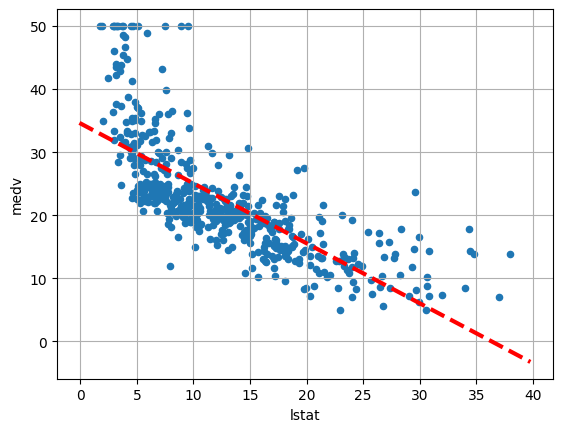

In [93]:
ax = df.plot.scatter('lstat', 'medv')
abline(
    ax,
    results.params[0],
    results.params[1],
    'r--',
    linewidth=3)

ax.grid()

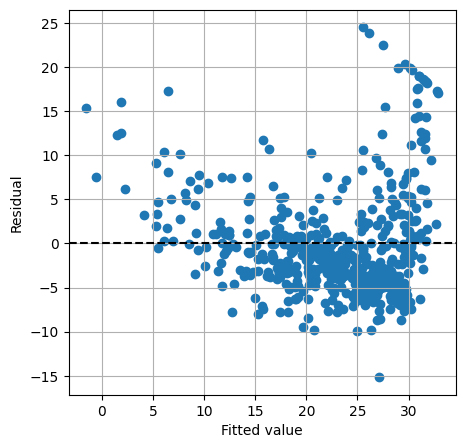

In [94]:
ax = plt.subplots(1,1,figsize=(5,5))[1]

ax.scatter(results.fittedvalues, results.resid)
ax.set_xlabel("Fitted value")
ax.set_ylabel("Residual")
ax.axhline(0, c="k", ls="--")

ax.grid()

Some non-linearity is present in the data

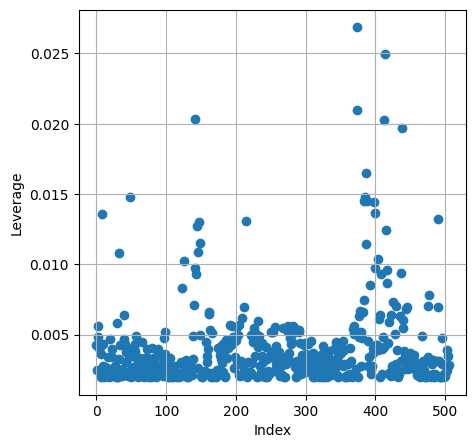

In [95]:
infl = results.get_influence()
ax = plt.subplots(figsize=(5,5))[1]
ax.scatter(np.arange(X.shape[0]), infl.hat_matrix_diag)
ax.set_xlabel('Index')
ax.set_ylabel('Leverage')
np.argmax(infl.hat_matrix_diag)

ax.grid()

## Multiple Linear Regression

### First model

In [96]:
x_cols = df.columns.drop("medv")

X = MS(x_cols).fit_transform(df)

model1 = sm.OLS(y, X)
results1 = model1.fit()

print(results1.summary())

                            OLS Regression Results                            
Dep. Variable:                   medv   R-squared:                       0.734
Model:                            OLS   Adj. R-squared:                  0.728
Method:                 Least Squares   F-statistic:                     113.5
Date:                Thu, 19 Jun 2025   Prob (F-statistic):          2.23e-133
Time:                        02:04:24   Log-Likelihood:                -1504.9
No. Observations:                 506   AIC:                             3036.
Df Residuals:                     493   BIC:                             3091.
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     41.6173      4.936      8.431      0.0

* F-Statistic significant
* most p-val of the coeff are significant
* Normality of error term violated (omnibus + JB test)

In [97]:
vals = [vif(X, i)
for i in range(1, X.shape[1])]
vif = pd.DataFrame({'vif':vals},
index=X.columns [1:])
vif

,vif
crim,1.767486
zn,2.298459
indus,3.987181
chas,1.071168
nox,4.369093
rm,1.912532
age,3.088232
dis,3.954037
rad,7.445301
tax,9.002158


Partly high vif and indication that there could be multi-colinearity

### Sklearn implementation

In [98]:
X[:4]

,intercept,crim,zn,indus,chas,nox,rm,age,dis,rad,tax,ptratio,lstat
0,1.0,0.00632,18.0,2.31,0,0.538,6.575,65.2,4.0900,1,296,15.3,4.98
1,1.0,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,2,242,17.8,9.14
2,1.0,0.02729,0.0,7.07,0,0.469,7.185,61.1,4.9671,2,242,17.8,4.03
3,1.0,0.03237,0.0,2.18,0,0.458,6.998,45.8,6.0622,3,222,18.7,2.94


In [99]:
y[:4]

0    24.0
1    21.6
2    34.7
3    33.4
Name: medv, dtype: float64

In [100]:
reg = LinearRegression()
reg.fit(X, y)

reg.coef_

array([ 0.00000000e+00, -1.21388618e-01,  4.69634633e-02,  1.34676947e-02,
        2.83999338e+00, -1.87580220e+01,  3.65811904e+00,  3.61071055e-03,
       -1.49075365e+00,  2.89404521e-01, -1.26819813e-02, -9.37532900e-01,
       -5.52019101e-01])

In [101]:
reg.score(X, y)

0.7343070437613076

### Interaction terms

In [102]:
X = MS(['lstat',
'age',
('lstat', 'age')]).fit_transform(df)
model2 = sm.OLS(y, X)
summarize(model2.fit())

,coef,std err,t,P>|t|
intercept,36.0885,1.470,24.553,0.000
lstat,-1.3921,0.167,-8.313,0.000
age,-0.0007,0.020,-0.036,0.971
lstat:age,0.0042,0.002,2.244,0.025


### Non-linear transformations of the predictors

In [103]:
X = MS([poly("lstat", degree = 2), 'age']).fit_transform(df)

model3 = sm.OLS(y, X)
results3 = model3.fit()

print(results3.summary())

                            OLS Regression Results                            
Dep. Variable:                   medv   R-squared:                       0.668
Model:                            OLS   Adj. R-squared:                  0.666
Method:                 Least Squares   F-statistic:                     337.3
Date:                Thu, 19 Jun 2025   Prob (F-statistic):          7.03e-120
Time:                        02:04:26   Log-Likelihood:                -1561.0
No. Observations:                 506   AIC:                             3130.
Df Residuals:                     502   BIC:                             3147.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
intercept               

#### Anova LM

In [104]:
anova_lm(results1, results3)

,df_resid,ssr,df_diff,ss_diff,F,Pr(>F)
0,493.0,11349.418808,0.0,NaN,NaN,NaN
1,502.0,14165.613251,-9.0,-2816.194443,11.0889,NaN


The anova_lm() function performs a hypothesis
test comparing the two models.

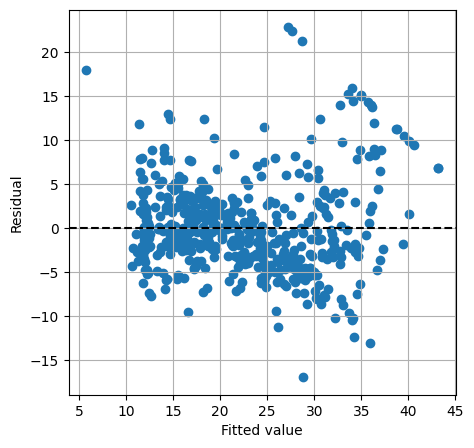

In [105]:
ax = plt.subplots(figsize=(5,5))[1]
ax.scatter(results3.fittedvalues , results3.resid)
ax.set_xlabel('Fitted value')
ax.set_ylabel('Residual')
ax.axhline(0, c='k', ls='--')

ax.grid()

### Sklearn implementation

In [107]:
X

,intercept,"poly(lstat, degree=2)[0]","poly(lstat, degree=2)[1]",age
0,1.0,-0.047815,0.038955,65.2
1,1.0,-0.021892,-0.010782,78.9
2,1.0,-0.053734,0.053604,61.1
3,1.0,-0.060527,0.071920,45.8
4,1.0,-0.045634,0.033866,54.2
...,...,...,...,...
501,1.0,-0.018589,-0.015433,69.1
502,1.0,-0.022265,-0.010231,76.7
503,1.0,-0.043702,0.029497,91.0
504,1.0,-0.038467,0.018316,89.3


In [127]:
X = MS(["lstat", 'age']).fit_transform(df)


poly = PolynomialFeatures(degree = 2, include_bias = False)

poly_features = poly.fit_transform(X[["lstat", "age"]])

In [131]:
poly_reg_model = LinearRegression()
poly_reg_model.fit(poly_features, y)

,fit_intercept,True
,copy_X,True
,tol,1e-06
,n_jobs,None
,positive,False


In [133]:
y_predicted = poly_reg_model.predict(poly_features)

In [139]:
r2_score(y_true = y, y_pred = y_predicted)

0.6817531981661779

### Qualitative Predictors

In [57]:
carseats = load_data("Carseats")
carseats.head()

,Sales,CompPrice,Income,Advertising,Population,Price,ShelveLoc,Age,Education,Urban,US
0,9.50,138,73,11,276,120,Bad,42,17,Yes,Yes
1,11.22,111,48,16,260,83,Good,65,10,Yes,Yes
2,10.06,113,35,10,269,80,Medium,59,12,Yes,Yes
3,7.40,117,100,4,466,97,Medium,55,14,Yes,Yes
4,4.15,141,64,3,340,128,Bad,38,13,Yes,No


In [61]:
#one hot encoding
allvars = list(carseats.columns.drop("Sales"))
y = carseats["Sales"].copy()

final_cols = allvars + [("Income", "Advertising"), ("Price", "Age")]

X = MS(final_cols).fit_transform(carseats)
model = sm.OLS(y, X)

print(model.fit().summary())

                            OLS Regression Results                            
Dep. Variable:                  Sales   R-squared:                       0.876
Model:                            OLS   Adj. R-squared:                  0.872
Method:                 Least Squares   F-statistic:                     210.0
Date:                Thu, 19 Jun 2025   Prob (F-statistic):          6.14e-166
Time:                        01:53:48   Log-Likelihood:                -564.67
No. Observations:                 400   AIC:                             1157.
Df Residuals:                     386   BIC:                             1213.
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
intercept              6.5756      1